# Proyecto final de Machine Learning

In [356]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [357]:
import warnings 
warnings.filterwarnings('ignore')

In [358]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

In [359]:
import sqlite3

### Fases del proyecto

#### Paso 1: Definición del problema

Predecir por medio de la implementación de un modelo de Machine Laerning y de acuerdo al conjunto de datos, si la persona diagnosticada con covid se recuperó, falleció por covid o fallecio por una razón diferente a covid.

#### Paso 2: Obtencion y carga del conjunto de datos

In [360]:
# Antes de ejecutar el código debemos asegurarnos de que hemos instalado las siguientes librerías
# pip install pandas
# pip install sodapy
from sodapy import Socrata

In [361]:
# Conexión API datos Colombia
client = Socrata("www.datos.gov.co", None)

In [362]:
# Primeros 100000 resultados, devueltos como JSON desde la API / convertidos a lista de diccionarios de Python por sodapy.
n = 100000
results = client.get("gt2j-8ykr", limit=n)

In [363]:
# Conversión de los datos a un DataFrame con Pandas
results_df = pd.DataFrame.from_records(results)
results_df.head()

,fecha_reporte_web,id_de_caso,fecha_de_notificaci_n,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,unidad_medida,sexo,...,recuperado,fecha_inicio_sintomas,fecha_diagnostico,fecha_recuperado,tipo_recuperacion,per_etn_,fecha_muerte,nom_grupo_,pais_viajo_1_cod,pais_viajo_1_nom
0,2020-12-24 00:00:00,1556979,2020-12-22 00:00:00,76,VALLE,76001,CALI,67,1,F,...,Recuperado,2020-12-21 00:00:00,2020-12-23 00:00:00,2021-01-04 00:00:00,Tiempo,6,NaN,NaN,NaN,NaN
1,2020-12-24 00:00:00,1556980,2020-12-19 00:00:00,76,VALLE,76001,CALI,66,1,F,...,Recuperado,2020-12-07 00:00:00,2020-12-23 00:00:00,2020-12-25 00:00:00,Tiempo,6,NaN,NaN,NaN,NaN
2,2020-12-24 00:00:00,1556981,2020-12-19 00:00:00,76,VALLE,76001,CALI,68,1,F,...,Recuperado,2020-12-18 00:00:00,2020-12-22 00:00:00,2021-01-01 00:00:00,Tiempo,6,NaN,NaN,NaN,NaN
3,2020-12-24 00:00:00,1556982,2020-12-22 00:00:00,76,VALLE,76001,CALI,74,1,F,...,Fallecido,2020-12-17 00:00:00,2020-12-23 00:00:00,NaN,NaN,6,2020-12-30 00:00:00,NaN,NaN,NaN
4,2020-12-24 00:00:00,1556983,2020-12-22 00:00:00,76,VALLE,76001,CALI,65,1,F,...,Recuperado,2020-12-21 00:00:00,2020-12-23 00:00:00,2021-01-04 00:00:00,Tiempo,6,NaN,NaN,NaN,NaN


Exploración y limpieza de los datos

In [364]:
# Dimensiones del DataFrame
results_df.shape

(100000, 23)

In [365]:
# Información acerca de los tipos de dato y valores no nulos del conjunto de datos.
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   fecha_reporte_web      100000 non-null  object
 1   id_de_caso             100000 non-null  object
 2   fecha_de_notificaci_n  100000 non-null  object
 3   departamento           100000 non-null  object
 4   departamento_nom       100000 non-null  object
 5   ciudad_municipio       100000 non-null  object
 6   ciudad_municipio_nom   100000 non-null  object
 7   edad                   100000 non-null  object
 8   unidad_medida          100000 non-null  object
 9   sexo                   100000 non-null  object
 10  fuente_tipo_contagio   100000 non-null  object
 11  ubicacion              100000 non-null  object
 12  estado                 100000 non-null  object
 13  recuperado             100000 non-null  object
 14  fecha_inicio_sintomas  92425 non-null   object
 15  f

In [366]:
# Identificación de los valores nulos, para cada una de las columnas del conjunto de datos
results_df.isnull().sum().sort_values(ascending=False)

pais_viajo_1_nom         99933
pais_viajo_1_cod         99933
nom_grupo_               98247
fecha_muerte             96635
fecha_inicio_sintomas     7575
tipo_recuperacion         3258
fecha_recuperado          3258
fecha_diagnostico          127
ciudad_municipio_nom         0
departamento_nom             0
ciudad_municipio             0
fecha_de_notificaci_n        0
id_de_caso                   0
fecha_reporte_web            0
departamento                 0
recuperado                   0
estado                       0
ubicacion                    0
fuente_tipo_contagio         0
unidad_medida                0
sexo                         0
edad                         0
per_etn_                     0
dtype: int64

#### Paso 3: Almacenar la información

In [367]:
database_name = 'casos_covid19_colombia.db'

In [368]:
conn = sqlite3.connect(database_name)

In [369]:
table_name = 'casos_positivos_covid'

In [370]:
results_df.to_sql(table_name, conn, if_exists='replace', index=False);

In [371]:
cursor = conn.cursor()

In [372]:
pulled_data = cursor.execute('SELECT * FROM casos_positivos_covid')

In [373]:
conn.commit()
conn.close()

#### Paso 4: Realiza un EDA completo

In [374]:
# Generación de una copia del conjunto de datos para realizar una limpieza de la información
data_c = results_df.copy()
data_c.head()

,fecha_reporte_web,id_de_caso,fecha_de_notificaci_n,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,unidad_medida,sexo,...,recuperado,fecha_inicio_sintomas,fecha_diagnostico,fecha_recuperado,tipo_recuperacion,per_etn_,fecha_muerte,nom_grupo_,pais_viajo_1_cod,pais_viajo_1_nom
0,2020-12-24 00:00:00,1556979,2020-12-22 00:00:00,76,VALLE,76001,CALI,67,1,F,...,Recuperado,2020-12-21 00:00:00,2020-12-23 00:00:00,2021-01-04 00:00:00,Tiempo,6,NaN,NaN,NaN,NaN
1,2020-12-24 00:00:00,1556980,2020-12-19 00:00:00,76,VALLE,76001,CALI,66,1,F,...,Recuperado,2020-12-07 00:00:00,2020-12-23 00:00:00,2020-12-25 00:00:00,Tiempo,6,NaN,NaN,NaN,NaN
2,2020-12-24 00:00:00,1556981,2020-12-19 00:00:00,76,VALLE,76001,CALI,68,1,F,...,Recuperado,2020-12-18 00:00:00,2020-12-22 00:00:00,2021-01-01 00:00:00,Tiempo,6,NaN,NaN,NaN,NaN
3,2020-12-24 00:00:00,1556982,2020-12-22 00:00:00,76,VALLE,76001,CALI,74,1,F,...,Fallecido,2020-12-17 00:00:00,2020-12-23 00:00:00,NaN,NaN,6,2020-12-30 00:00:00,NaN,NaN,NaN
4,2020-12-24 00:00:00,1556983,2020-12-22 00:00:00,76,VALLE,76001,CALI,65,1,F,...,Recuperado,2020-12-21 00:00:00,2020-12-23 00:00:00,2021-01-04 00:00:00,Tiempo,6,NaN,NaN,NaN,NaN


In [375]:
# Verificación de la identificación de caso única, para evitar utilizar datos duplicados
data_c['id_de_caso'].nunique()

100000

In [376]:
# Eliminación de información irrelevante
data_c = data_c.drop(columns=['fecha_reporte_web', 'id_de_caso', 'fecha_de_notificaci_n', 'fecha_inicio_sintomas', 'fecha_recuperado', 'fecha_muerte', 'nom_grupo_'])
data_c.head()

,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,unidad_medida,sexo,fuente_tipo_contagio,ubicacion,estado,recuperado,fecha_diagnostico,tipo_recuperacion,per_etn_,pais_viajo_1_cod,pais_viajo_1_nom
0,76,VALLE,76001,CALI,67,1,F,Comunitaria,Casa,Leve,Recuperado,2020-12-23 00:00:00,Tiempo,6,NaN,NaN
1,76,VALLE,76001,CALI,66,1,F,Comunitaria,Casa,Leve,Recuperado,2020-12-23 00:00:00,Tiempo,6,NaN,NaN
2,76,VALLE,76001,CALI,68,1,F,Comunitaria,Casa,Leve,Recuperado,2020-12-22 00:00:00,Tiempo,6,NaN,NaN
3,76,VALLE,76001,CALI,74,1,F,Comunitaria,Fallecido,Fallecido,Fallecido,2020-12-23 00:00:00,NaN,6,NaN,NaN
4,76,VALLE,76001,CALI,65,1,F,Comunitaria,Casa,Leve,Recuperado,2020-12-23 00:00:00,Tiempo,6,NaN,NaN


In [377]:
# Fecha de diagnostico
# Cambiando el formato de la columna 'fecha_diagnostico'
data_c['fecha_diagnostico'] = pd.to_datetime(data_c['fecha_diagnostico'].str.split(' ').str[0], format = '%Y-%m-%d')

In [378]:
# Generamos columnas para el día, mes y año
data_c['año'] = data_c['fecha_diagnostico'].dt.year.astype('Int64')
data_c['mes'] = data_c['fecha_diagnostico'].dt.month.astype('Int64')
data_c['dia'] = data_c['fecha_diagnostico'].dt.day.astype('Int64')
data_c.head()

,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,unidad_medida,sexo,fuente_tipo_contagio,ubicacion,estado,recuperado,fecha_diagnostico,tipo_recuperacion,per_etn_,pais_viajo_1_cod,pais_viajo_1_nom,año,mes,dia
0,76,VALLE,76001,CALI,67,1,F,Comunitaria,Casa,Leve,Recuperado,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23
1,76,VALLE,76001,CALI,66,1,F,Comunitaria,Casa,Leve,Recuperado,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23
2,76,VALLE,76001,CALI,68,1,F,Comunitaria,Casa,Leve,Recuperado,2020-12-22,Tiempo,6,NaN,NaN,2020,12,22
3,76,VALLE,76001,CALI,74,1,F,Comunitaria,Fallecido,Fallecido,Fallecido,2020-12-23,NaN,6,NaN,NaN,2020,12,23
4,76,VALLE,76001,CALI,65,1,F,Comunitaria,Casa,Leve,Recuperado,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23


In [379]:
# Cambiando el formato de las columnas en valores numericos
data_c['departamento'] = data_c['departamento'].astype(int)

In [380]:
# Código DIVIPOLA municipio
data_c['ciudad_municipio'] = data_c['ciudad_municipio'].astype(int)

In [381]:
# Pertenencia étnica
#1-Indígena 2-ROM 3-Raizal 4-Palenquero 5-Negro 6-Otro
data_c['per_etn_'] = data_c['per_etn_'].astype(int)

In [382]:
# Edad
data_c['edad'] = data_c['edad'].astype(int)

In [383]:
# Unidad de medida de edad
# 1-Años 2-Meses 3-Días
data_c['unidad_medida'] = data_c['unidad_medida'].astype(int)

In [384]:
data_c.loc[data_c['unidad_medida'] == 2, 'edad'] = data_c['edad'] / 12
data_c.loc[data_c['unidad_medida'] == 3, 'edad'] = data_c['edad'] / 365
data_c['edad'] = data_c['edad'].round()

In [385]:
edad = data_c["edad"].value_counts()

<Figure size 1200x1000 with 0 Axes>

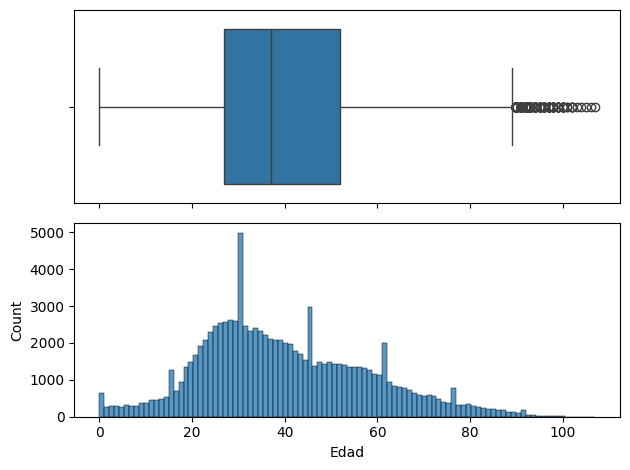

In [386]:
plt.figure(figsize=(12,10))
f,(box,hist)=plt.subplots(2,sharex=True)
sns.histplot(x=data_c["edad"],ax=hist)
sns.boxplot(x=data_c["edad"],ax=box)
plt.xlabel('Edad')
plt.tight_layout()
plt.show()

In [387]:
data_c = data_c.drop(columns=['unidad_medida'])
data_c.head()

,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,sexo,fuente_tipo_contagio,ubicacion,estado,recuperado,fecha_diagnostico,tipo_recuperacion,per_etn_,pais_viajo_1_cod,pais_viajo_1_nom,año,mes,dia
0,76,VALLE,76001,CALI,67.0,F,Comunitaria,Casa,Leve,Recuperado,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23
1,76,VALLE,76001,CALI,66.0,F,Comunitaria,Casa,Leve,Recuperado,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23
2,76,VALLE,76001,CALI,68.0,F,Comunitaria,Casa,Leve,Recuperado,2020-12-22,Tiempo,6,NaN,NaN,2020,12,22
3,76,VALLE,76001,CALI,74.0,F,Comunitaria,Fallecido,Fallecido,Fallecido,2020-12-23,NaN,6,NaN,NaN,2020,12,23
4,76,VALLE,76001,CALI,65.0,F,Comunitaria,Casa,Leve,Recuperado,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23


Colombia está dividida en 32 departamentos, cada uno con una capital. La capital del país es Bogotá, que también es un distrito capital. Teniendo esto en cuenta se realizó la limpieza de los datos, obteniendo los 32 departamentos que conforman la división política de Colombia y el Distrito Capital.

In [388]:
# Ver pares únicos de código y nombre para cada departamento
unique_pairs_d = data_c[['departamento', 'departamento_nom']].drop_duplicates()
unique_pairs_d

,departamento,departamento_nom
0,76,VALLE
14,5,ANTIOQUIA
15,68,SANTANDER
16,54,NORTE SANTANDER
17,17,CALDAS
19,11,BOGOTA
20,25,CUNDINAMARCA
23,18,CAQUETA
25,63,QUINDIO
27,66,RISARALDA


In [389]:
print(len(unique_pairs_d))

36


In [390]:
data_c['departamento'] = data_c['departamento'].replace(47001, 47)
data_c['departamento'] = data_c['departamento'].replace(8001, 8)
data_c['departamento'] = data_c['departamento'].replace(13001, 13)

In [391]:
data_c['departamento_nom'] = data_c['departamento_nom'].replace('STA MARTA D.E.', 'MAGDALENA')
data_c['departamento_nom'] = data_c['departamento_nom'].replace('BARRANQUILLA', 'ATLANTICO')
data_c['departamento_nom'] = data_c['departamento_nom'].replace('CARTAGENA', 'BOLIVAR')

In [392]:
unique_pairs_d = data_c[['departamento', 'departamento_nom']].drop_duplicates()
print(len(unique_pairs_d))

33


In [393]:
# Ver pares únicos de código y nombre para cada municipio
unique_pairs_c = data_c[['ciudad_municipio', 'ciudad_municipio_nom']].drop_duplicates()
unique_pairs_c

,ciudad_municipio,ciudad_municipio_nom
0,76001,CALI
14,5266,ENVIGADO
15,68001,BUCARAMANGA
16,54001,CUCUTA
17,17001,MANIZALES
...,...,...
97473,54109,BUCARASICA
97740,8549,PIOJO
97813,19418,LOPEZ (MICAY)
98379,15218,COVARACHIA


In [394]:
# ¿Hay códigos con más de un nombre?
print(unique_pairs_c.groupby('ciudad_municipio')['ciudad_municipio_nom'].nunique().sort_values(ascending=False))

ciudad_municipio
99773    1
5001     1
5002     1
5004     1
5021     1
        ..
5059     1
5055     1
5051     1
5045     1
5044     1
Name: ciudad_municipio_nom, Length: 955, dtype: int64


In [395]:
departamento_nom = data_c["departamento_nom"].value_counts()

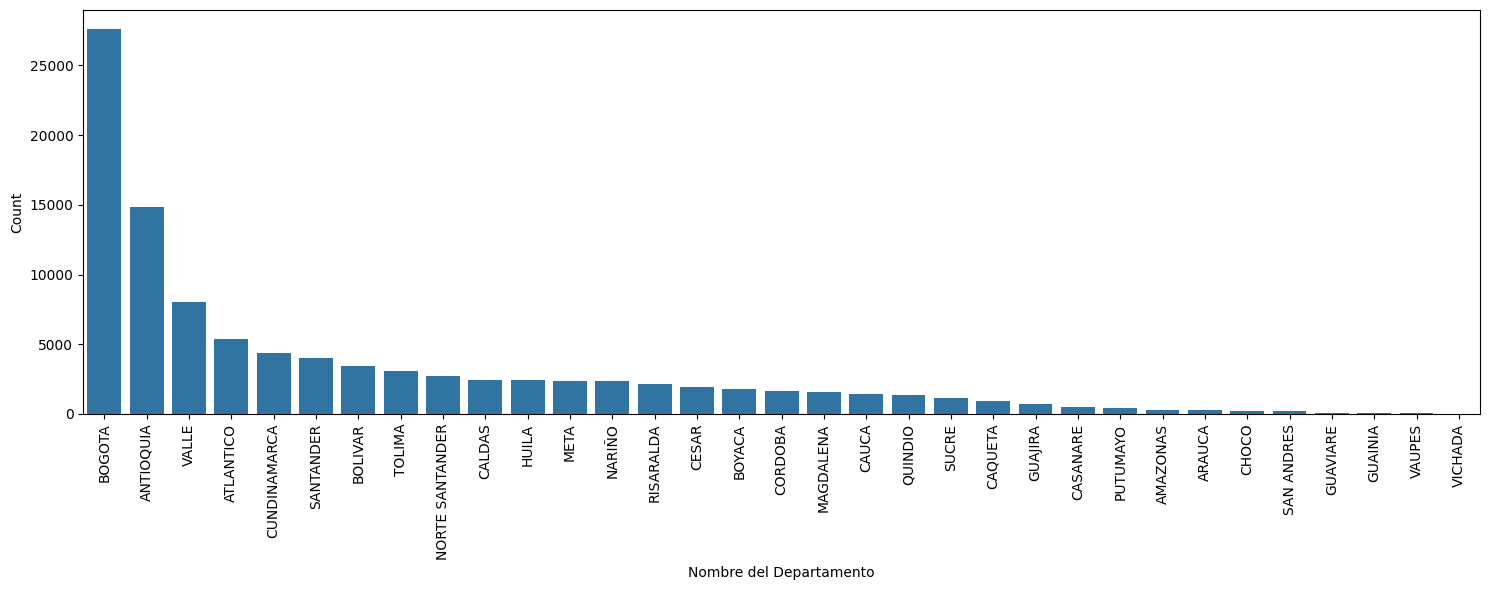

In [396]:
plt.figure(figsize=(15,6))
sns.barplot(x=departamento_nom.index, y=departamento_nom.values).set(xlabel = "Nombre del Departamento", ylabel = "Count", title = None)
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [397]:
# Sexo
sexo=data_c["sexo"].value_counts()
print(f"{sexo}")

sexo
F    50372
M    49628
Name: count, dtype: int64


In [398]:
# data_c['sexo'] = data_c['sexo'].replace('f', 'F')
# sexo=data_c["sexo"].value_counts()

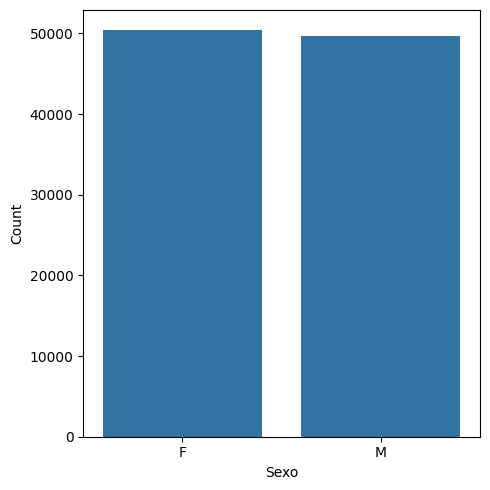

In [443]:
plt.figure(figsize=(5,5))
ax = sns.barplot(x=sexo.index, y=sexo.values).set(xlabel = "Sexo", ylabel = "Count", title = None)

plt.tight_layout()
plt.show()

In [400]:
data_c = pd.get_dummies(data_c, columns = ['sexo'])

In [401]:
data_c['sexo_F'] = data_c['sexo_F'].astype(int)
data_c['sexo_M'] = data_c['sexo_M'].astype(int)
data_c.head()

,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,fuente_tipo_contagio,ubicacion,estado,recuperado,fecha_diagnostico,tipo_recuperacion,per_etn_,pais_viajo_1_cod,pais_viajo_1_nom,año,mes,dia,sexo_F,sexo_M
0,76,VALLE,76001,CALI,67.0,Comunitaria,Casa,Leve,Recuperado,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23,1,0
1,76,VALLE,76001,CALI,66.0,Comunitaria,Casa,Leve,Recuperado,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23,1,0
2,76,VALLE,76001,CALI,68.0,Comunitaria,Casa,Leve,Recuperado,2020-12-22,Tiempo,6,NaN,NaN,2020,12,22,1,0
3,76,VALLE,76001,CALI,74.0,Comunitaria,Fallecido,Fallecido,Fallecido,2020-12-23,NaN,6,NaN,NaN,2020,12,23,1,0
4,76,VALLE,76001,CALI,65.0,Comunitaria,Casa,Leve,Recuperado,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23,1,0


In [402]:
fuente_tipo_contagio = data_c["fuente_tipo_contagio"].value_counts()
print(f"{fuente_tipo_contagio}")

fuente_tipo_contagio
Comunitaria    76360
Relacionado    23573
Importado         67
Name: count, dtype: int64


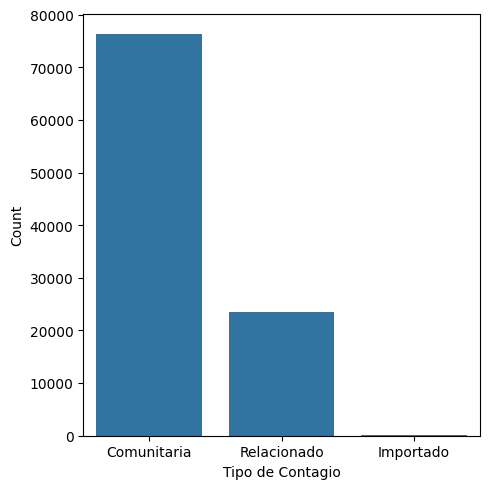

In [403]:
plt.figure(figsize=(5,5))
sns.barplot(x=fuente_tipo_contagio.index, y=fuente_tipo_contagio.values).set(xlabel = "Tipo de Contagio", ylabel = "Count", title = None)
#plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [404]:
# Factorizando los datos de la variable fuente_tipo_contagio
data_c["fuente_tipo_contagio"] = pd.factorize(data_c["fuente_tipo_contagio"])[0]
fuente_tipo_contagio = data_c["fuente_tipo_contagio"].value_counts()
print(f"{fuente_tipo_contagio}")

fuente_tipo_contagio
0    76360
1    23573
2       67
Name: count, dtype: int64


In [405]:
# * Corresponde a muertes no relacionadas con COVID-19, aún si eran casos activos **Hay pacientes recuperados para COVID-19, que pueden permanecer en hospitalización por otras comorbilidades
ubicacion = data_c["ubicacion"].value_counts()
print(f"{ubicacion}")

ubicacion
Casa         96630
Fallecido     2809
N/A            556
casa             5
Name: count, dtype: int64


In [406]:
data_c['ubicacion'] = data_c['ubicacion'].replace('casa', 'Casa')

In [407]:
# * Corresponde a muertes no relacionadas con COVID-19, aún si eran casos activos **Hay pacientes recuperados para COVID-19, que pueden permanecer en hospitalización por otras comorbilidades
estado = data_c["estado"].value_counts()
print(f"{estado}")

estado
Leve         96630
Fallecido     2809
N/A            556
leve             5
Name: count, dtype: int64


In [408]:
data_c['estado'] = data_c['estado'].replace('leve', 'Leve')

In [409]:
# Factorizando los datos de la variable estado
data_c["estado"] = pd.factorize(data_c["estado"])[0]
estado = data_c["estado"].value_counts()
print(f"{estado}")

estado
0    96635
1     2809
2      556
Name: count, dtype: int64


In [410]:
# Recuperado Fallecido N/A (Vacío). N/A se refiere a los fallecidos no COVID. 
# Pueden haber casos recuperados con ubicación Hospital u Hospital UCI, ya que permanecen en hospitalización por causas diferentes. 
# Los casos con información en blanco en esta columna corresponde a los casos activos
recuperado = data_c["recuperado"].value_counts()
print(f"{recuperado}")

recuperado
Recuperado    96742
Fallecido      2799
N/A             449
fallecido        10
Name: count, dtype: int64


In [411]:
data_c['recuperado'] = data_c['recuperado'].replace('fallecido', 'Fallecido')
data_c['recuperado'] = data_c['recuperado'].replace('N/A', 'Fallecido No Covid')
recuperado = data_c["recuperado"].value_counts()
print(f"{recuperado}")

recuperado
Recuperado            96742
Fallecido              2809
Fallecido No Covid      449
Name: count, dtype: int64


In [412]:
p_recuperado = round(((recuperado/n)*(100)),2)
p_recuperado

recuperado
Recuperado            96.74
Fallecido              2.81
Fallecido No Covid     0.45
Name: count, dtype: float64

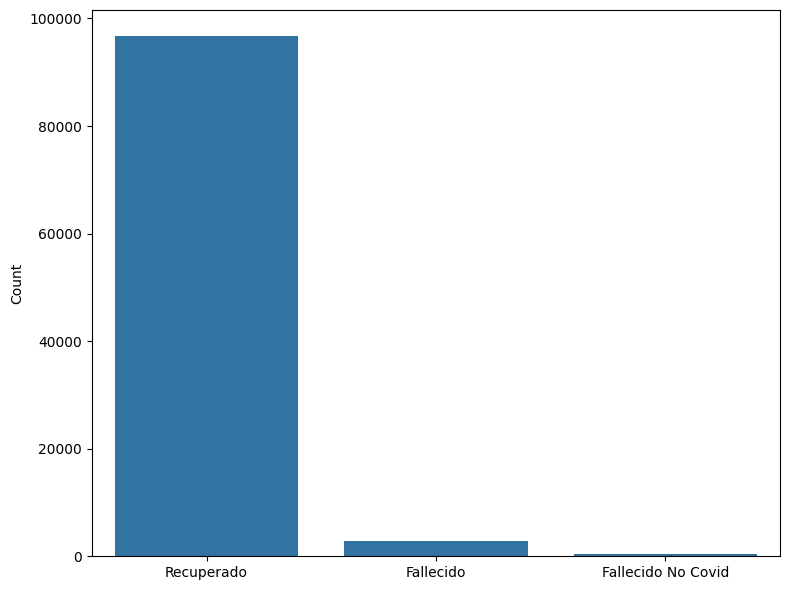

In [413]:
plt.figure(figsize=(8,6))
sns.barplot(x=recuperado.index, y=recuperado.values).set(xlabel = None, ylabel = "Count", title = None)
#plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [414]:
# Factorizando los datos de la variable recuperado
data_c["recuperado"] = pd.factorize(data_c["recuperado"])[0]
recuperado = data_c["recuperado"].value_counts()
print(f"{recuperado}")

recuperado
0    96742
1     2809
2      449
Name: count, dtype: int64


En este caso evidenciamos que las variables estado, ubicación y recuperado manejan los mismos datos, por lo que decidimos eliminar estado y ubicación con el objetivo de simplificar el conjunto de datos.

In [415]:
data_c = data_c.drop(columns=['ubicacion', 'estado'])
data_c.head()

,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,fuente_tipo_contagio,recuperado,fecha_diagnostico,tipo_recuperacion,per_etn_,pais_viajo_1_cod,pais_viajo_1_nom,año,mes,dia,sexo_F,sexo_M
0,76,VALLE,76001,CALI,67.0,0,0,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23,1,0
1,76,VALLE,76001,CALI,66.0,0,0,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23,1,0
2,76,VALLE,76001,CALI,68.0,0,0,2020-12-22,Tiempo,6,NaN,NaN,2020,12,22,1,0
3,76,VALLE,76001,CALI,74.0,0,1,2020-12-23,NaN,6,NaN,NaN,2020,12,23,1,0
4,76,VALLE,76001,CALI,65.0,0,0,2020-12-23,Tiempo,6,NaN,NaN,2020,12,23,1,0


In [416]:
# Se refiere a la variable de tipo de recuperación que tiene dos opciones: PCR y tiempo. 
# PCR indica que la persona se encuentra recuperada por segunda muestra, en donde dio negativo para el virus; 
# Tiempo significa que son personas que cumplieron 30 días posteriores al inicio de síntomas o toma de muestras que no tienen síntomas, 
# que no tengan más de 70 años ni que estén hospitalizados.
data_c['tipo_recuperacion'] = data_c['tipo_recuperacion'].replace('NaN', np.nan)
tipo_recuperacion = data_c["tipo_recuperacion"].value_counts()
print(f"{tipo_recuperacion}")

tipo_recuperacion
Tiempo    75705
PCR       21037
Name: count, dtype: int64


In [417]:
# Factorizando los datos de la variable tipo_recuperacion
data_c["tipo_recuperacion"] = pd.factorize(data_c["tipo_recuperacion"])[0]
tipo_recuperacion = data_c["tipo_recuperacion"].value_counts()
print(f"{tipo_recuperacion}")

tipo_recuperacion
 0    75705
 1    21037
-1     3258
Name: count, dtype: int64


In [418]:
# Nombre del país
pais_viajo_1_nom = data_c["pais_viajo_1_nom"].value_counts()
print(f"{pais_viajo_1_nom}")

pais_viajo_1_nom
ESTADOS UNIDOS DE AMÉRICA    27
MÉXICO                       11
BRASIL                        6
REPÚBLICA DOMINICANA          5
ECUADOR                       4
PERÚ                          2
ESPAÑA                        2
EL SALVADOR                   2
PORTUGAL                      1
FRANCIA                       1
ALEMANIA                      1
PANAMÁ                        1
ARMENIA                       1
EMIRATOS ARABES UNIDOS        1
NORUEGA                       1
DOMINICA                      1
Name: count, dtype: int64


In [419]:
# Código ISO del país
pais_viajo_1_cod = data_c["pais_viajo_1_cod"].value_counts()
print(f"{pais_viajo_1_cod}")

pais_viajo_1_cod
840    27
484    11
76      6
214     5
218     4
604     2
724     2
222     2
620     1
250     1
276     1
591     1
51      1
784     1
578     1
212     1
Name: count, dtype: int64


In [420]:
data_c['viajo'] = np.where(data_c['pais_viajo_1_cod'].notna() & (data_c['pais_viajo_1_cod'].str.strip() != ''), 1, 0)

In [421]:
print(data_c['viajo'].value_counts())

viajo
0    99933
1       67
Name: count, dtype: int64


In [422]:
data_c = data_c.sort_values(by='fecha_diagnostico')
data_c.reset_index(drop=True, inplace=True)
data_c.head()

,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,fuente_tipo_contagio,recuperado,fecha_diagnostico,tipo_recuperacion,per_etn_,pais_viajo_1_cod,pais_viajo_1_nom,año,mes,dia,sexo_F,sexo_M,viajo
0,91,AMAZONAS,91001,LETICIA,60.0,2,1,2020-04-21,-1,6,76,BRASIL,2020,4,21,0,1,1
1,76,VALLE,76001,CALI,27.0,1,0,2020-04-22,1,6,NaN,NaN,2020,4,22,0,1,0
2,50,META,50001,VILLAVICENCIO,30.0,1,0,2020-05-02,1,6,NaN,NaN,2020,5,2,1,0,0
3,8,ATLANTICO,8001,BARRANQUILLA,28.0,0,0,2020-05-08,1,6,NaN,NaN,2020,5,8,1,0,0
4,8,ATLANTICO,8001,BARRANQUILLA,88.0,0,1,2020-05-11,-1,6,NaN,NaN,2020,5,11,0,1,0


In [423]:
data_c.columns

Index(['departamento', 'departamento_nom', 'ciudad_municipio',
       'ciudad_municipio_nom', 'edad', 'fuente_tipo_contagio', 'recuperado',
       'fecha_diagnostico', 'tipo_recuperacion', 'per_etn_',
       'pais_viajo_1_cod', 'pais_viajo_1_nom', 'año', 'mes', 'dia', 'sexo_F',
       'sexo_M', 'viajo'],
      dtype='object')

In [424]:
len(data_c.columns)

18

In [425]:
data_c=data_c.reindex(['fecha_diagnostico', 'año', 'mes', 'dia', 'departamento_nom', 'departamento', 'ciudad_municipio_nom', 'ciudad_municipio', 'edad', 'sexo_F', 'sexo_M', 'fuente_tipo_contagio',
                        'recuperado', 'tipo_recuperacion', 'per_etn_', 'viajo', 'pais_viajo_1_cod', 'pais_viajo_1_nom'], axis=1)
data_c.head()

,fecha_diagnostico,año,mes,dia,departamento_nom,departamento,ciudad_municipio_nom,ciudad_municipio,edad,sexo_F,sexo_M,fuente_tipo_contagio,recuperado,tipo_recuperacion,per_etn_,viajo,pais_viajo_1_cod,pais_viajo_1_nom
0,2020-04-21,2020,4,21,AMAZONAS,91,LETICIA,91001,60.0,0,1,2,1,-1,6,1,76,BRASIL
1,2020-04-22,2020,4,22,VALLE,76,CALI,76001,27.0,0,1,1,0,1,6,0,NaN,NaN
2,2020-05-02,2020,5,2,META,50,VILLAVICENCIO,50001,30.0,1,0,1,0,1,6,0,NaN,NaN
3,2020-05-08,2020,5,8,ATLANTICO,8,BARRANQUILLA,8001,28.0,1,0,0,0,1,6,0,NaN,NaN
4,2020-05-11,2020,5,11,ATLANTICO,8,BARRANQUILLA,8001,88.0,0,1,0,1,-1,6,0,NaN,NaN


In [426]:
data_clean = data_c.copy()

In [427]:
# Recuperando la columna original
data_clean['sexo'] = data_clean[['sexo_F', 'sexo_M']].idxmax(axis=1)
data_clean['sexo'] = data_clean['sexo'].str.replace('sexo_', '')
data_clean = data_clean.drop(columns=['departamento', 'ciudad_municipio_nom', 'ciudad_municipio', 'sexo_F', 'sexo_M', 'pais_viajo_1_cod'])
data_clean['fuente_tipo_contagio'] = data_clean['fuente_tipo_contagio'].map({0: 'Comunitaria', 1: 'Relacionado', 2: 'Importado'})
data_clean['recuperado'] = data_clean['recuperado'].map({0: 'Recuperado', 1: 'Fallecido', 2: 'Fallecido No Covid'})
data_clean['tipo_recuperacion'] = data_clean['tipo_recuperacion'].map({0: 'Tiempo', 1: 'PCR', -1: np.nan})
data_clean['per_etn_'] = data_clean['per_etn_'].map({1: 'Indígena', 2: 'ROM-Gitano', 3: 'Raizal', 4: 'Palenquero', 5: 'Negro', 6: 'Otro'})
data_clean.head()

,fecha_diagnostico,año,mes,dia,departamento_nom,edad,fuente_tipo_contagio,recuperado,tipo_recuperacion,per_etn_,viajo,pais_viajo_1_nom,sexo
0,2020-04-21,2020,4,21,AMAZONAS,60.0,Importado,Fallecido,NaN,Otro,1,BRASIL,M
1,2020-04-22,2020,4,22,VALLE,27.0,Relacionado,Recuperado,PCR,Otro,0,NaN,M
2,2020-05-02,2020,5,2,META,30.0,Relacionado,Recuperado,PCR,Otro,0,NaN,F
3,2020-05-08,2020,5,8,ATLANTICO,28.0,Comunitaria,Recuperado,PCR,Otro,0,NaN,F
4,2020-05-11,2020,5,11,ATLANTICO,88.0,Comunitaria,Fallecido,NaN,Otro,0,NaN,M


In [428]:
data_clean.shape

(100000, 13)

In [429]:
fecha_inicial = data_clean['fecha_diagnostico'].iloc[0]
fecha_final   = data_clean['fecha_diagnostico'].dropna().iloc[-1]
print(f'Initial date: {fecha_inicial}')
print(f'Final date  : {fecha_final}')

Initial date: 2020-04-21 00:00:00
Final date  : 2021-12-22 00:00:00


In [446]:
bins = list(range(0, 101, 10)) + [150]  # hasta 150 para cubrir valores extremos
labels = [f"{i}-{i+9}" for i in range(0, 100, 10)] + ["100+"]

data_clean['grupo_edad'] = pd.cut(data_clean['edad'], bins=bins, labels=labels, right=False)
data_clean.head()

,fecha_diagnostico,año,mes,dia,departamento_nom,edad,fuente_tipo_contagio,recuperado,tipo_recuperacion,per_etn_,viajo,pais_viajo_1_nom,sexo,grupo_edad
0,2020-04-21,2020,4,21,AMAZONAS,60.0,Importado,Fallecido,NaN,Otro,1,BRASIL,M,60-69
1,2020-04-22,2020,4,22,VALLE,27.0,Relacionado,Recuperado,PCR,Otro,0,NaN,M,20-29
2,2020-05-02,2020,5,2,META,30.0,Relacionado,Recuperado,PCR,Otro,0,NaN,F,30-39
3,2020-05-08,2020,5,8,ATLANTICO,28.0,Comunitaria,Recuperado,PCR,Otro,0,NaN,F,20-29
4,2020-05-11,2020,5,11,ATLANTICO,88.0,Comunitaria,Fallecido,NaN,Otro,0,NaN,M,80-89


In [447]:
fallecidos_df = data_clean[data_clean['recuperado'] == 'Fallecido']
fallecidos_df.head()

,fecha_diagnostico,año,mes,dia,departamento_nom,edad,fuente_tipo_contagio,recuperado,tipo_recuperacion,per_etn_,viajo,pais_viajo_1_nom,sexo,grupo_edad
0,2020-04-21,2020,4,21,AMAZONAS,60.0,Importado,Fallecido,NaN,Otro,1,BRASIL,M,60-69
4,2020-05-11,2020,5,11,ATLANTICO,88.0,Comunitaria,Fallecido,NaN,Otro,0,NaN,M,80-89
28,2020-05-14,2020,5,14,MAGDALENA,75.0,Relacionado,Fallecido,NaN,Otro,0,NaN,M,70-79
126,2020-05-15,2020,5,15,BOLIVAR,75.0,Comunitaria,Fallecido,NaN,Indígena,0,NaN,F,70-79
163,2020-05-15,2020,5,15,NARIÑO,65.0,Relacionado,Fallecido,NaN,Otro,0,NaN,F,60-69


In [449]:
fallecidos_df.shape

(2809, 14)

In [451]:
grupo_fallecidos = fallecidos_df['grupo_edad'].value_counts().sort_index()
grupo_fallecidos

grupo_edad
0-9        3
10-19      7
20-29     29
30-39     80
40-49    175
50-59    336
60-69    681
70-79    747
80-89    606
90-99    138
100+       7
Name: count, dtype: int64

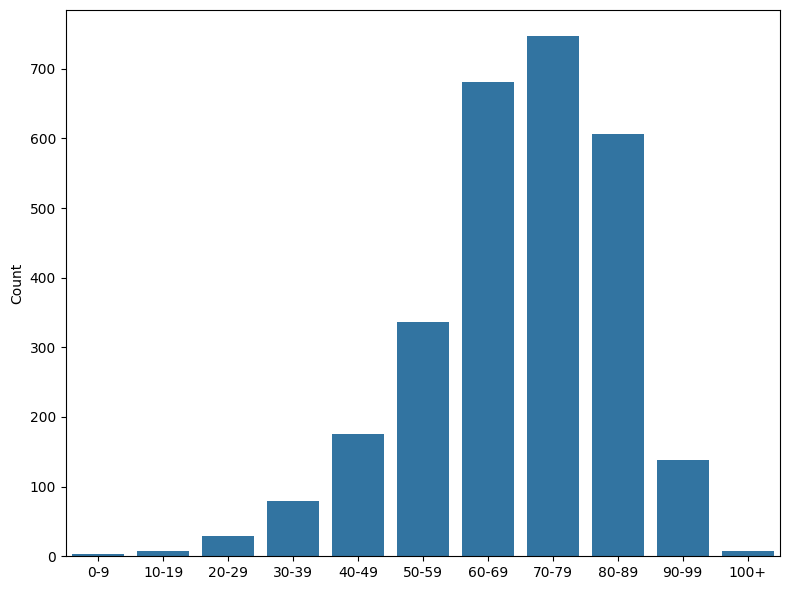

In [454]:
plt.figure(figsize=(8,6))
sns.barplot(x=grupo_fallecidos.index, y=grupo_fallecidos.values).set(xlabel = None, ylabel = "Count", title = None)
#plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [430]:
# Pertenencia étnica
#1-Indígena 2-ROM 3-Raizal 4-Palenquero 5-Negro 6-Otro
per_etn_ = data_clean["per_etn_"].value_counts()
print(f"{per_etn_}")

per_etn_
Otro          94210
Negro          3993
Indígena       1766
Raizal           30
ROM-Gitano        1
Name: count, dtype: int64


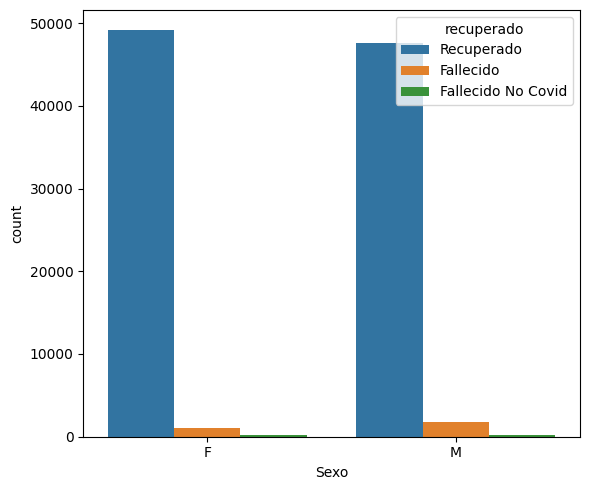

In [445]:
fig, axis = plt.subplots(figsize = (6, 5))
orden_sexo = ['F', 'M']
orden_recuperado = ['Recuperado', 'Fallecido', 'Fallecido No Covid']
sns.countplot(data = data_clean, x = "sexo", hue = "recuperado", order = orden_sexo, hue_order = orden_recuperado)
#plt.xticks(rotation=90)
plt.xlabel("Sexo")
plt.tight_layout()
plt.show()

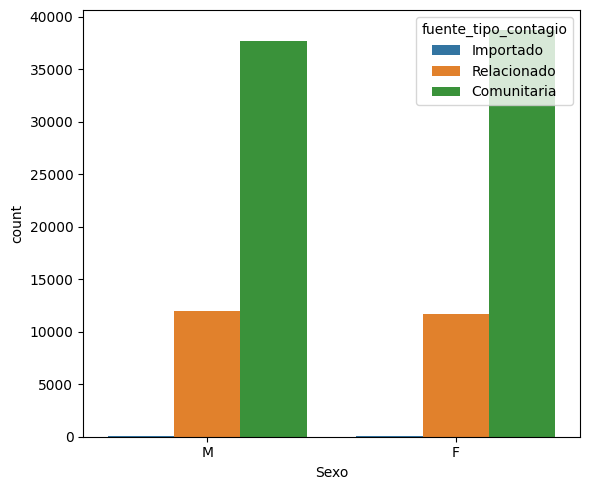

In [432]:
fig, axis = plt.subplots(figsize = (6, 5))

sns.countplot(data = data_clean, x = "sexo", hue = "fuente_tipo_contagio")
#plt.xticks(rotation=90)
plt.xlabel("Sexo")
plt.tight_layout()
plt.show()

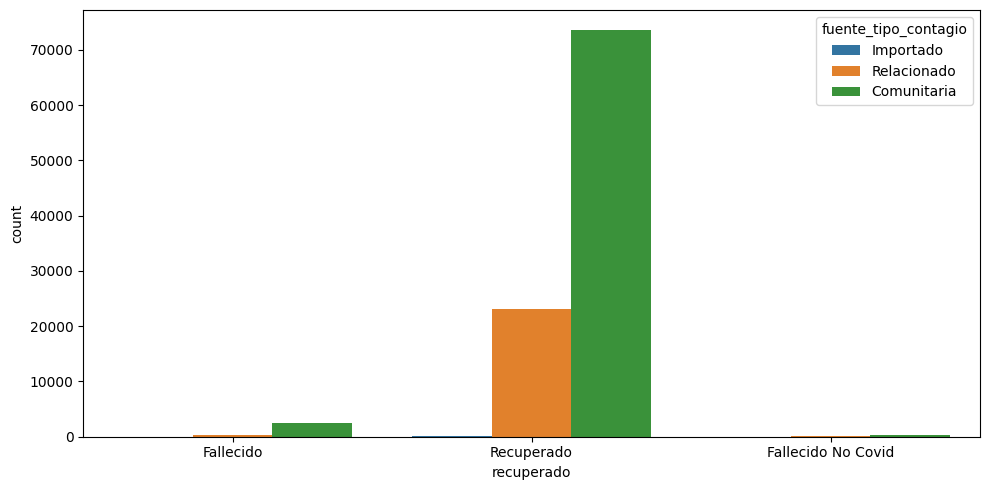

In [433]:
fig, axis = plt.subplots(figsize=(10, 5))

sns.countplot(data=data_clean, x="recuperado", hue="fuente_tipo_contagio")

plt.tight_layout()
plt.show()

In [434]:
numerical_columns = ['recuperado', 'año', 'mes', 'dia', 'departamento', 'edad', 'sexo_F', 'sexo_M', 'fuente_tipo_contagio', 'tipo_recuperacion', 'per_etn_', 'viajo']

<Axes: >

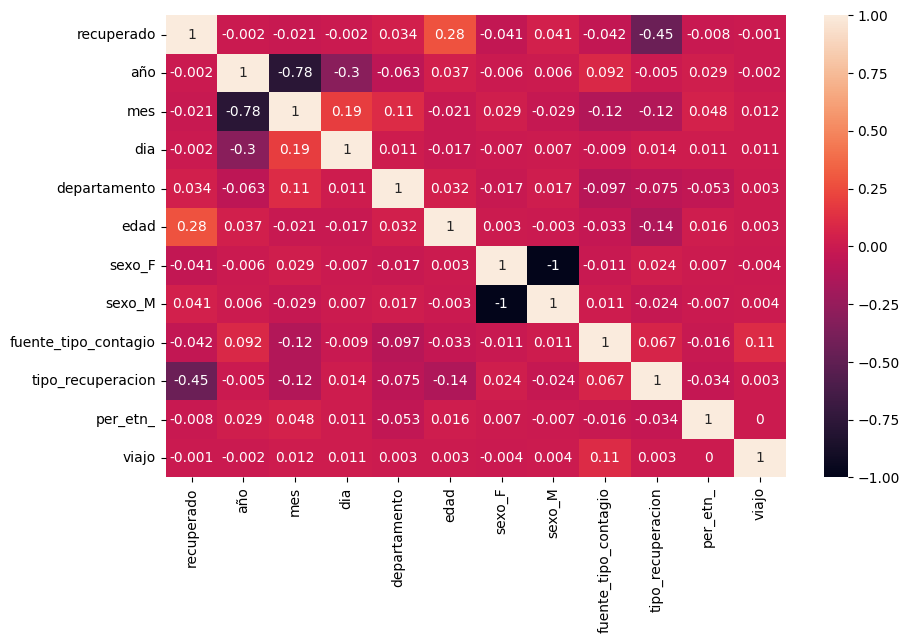

In [435]:
plt.figure(figsize=(10,6))
sns.heatmap(data_c[numerical_columns].corr().round(3),vmax=1,vmin=-1,annot=True)

#### Paso 5: Construye el modelo y optimízalo

In [436]:
feature_columns=['año', 'mes', 'dia', 'departamento', 'edad', 'sexo_F', 'sexo_M', 'fuente_tipo_contagio', 'tipo_recuperacion']

In [437]:
X=data_c[feature_columns]
Y=data_c[['recuperado']]

In [438]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [439]:
# Create Decision Tree classifer object
model = DecisionTreeClassifier()

# Train Decision Tree Classifer
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [440]:
y_pred = model.predict(X_test)

In [441]:
accuracy=metrics.accuracy_score(y_test, y_pred)
accuracy

0.99235